In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [3]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

In [4]:
image_folder_path = '../data/MFCC2'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [5]:
X_all = []
Y_all = []

image_folder_path = '../data/MFCC2'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [6]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 112, 170, 3)
(3018,)


<h2>K-Fold Training and Evaluation</h2>

In [7]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Flatten()(lay)

    lay = Dense(48)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [24]:
model = build_current_model()
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 56, 85, 56)        8288      
_________________________________________________________________
batch_normalization_60 (Batc (None, 56, 85, 56)        224       
_________________________________________________________________
activation_60 (Activation)   (None, 56, 85, 56)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 28, 43, 56)        0         
_________________________________________________________________
spatial_dropout2d_48 (Spatia (None, 28, 43, 56)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 14, 22, 72)        100

In [25]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()


n_split=5
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
           
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_split=0.1,
              verbose=2)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Epoch 1/100
272/272 - 2s - loss: 1.5022 - accuracy: 0.5281 - val_loss: 1.4304 - val_accuracy: 0.5413
Epoch 2/100
272/272 - 2s - loss: 1.3147 - accuracy: 0.5732 - val_loss: 1.9667 - val_accuracy: 0.5248
Epoch 3/100
272/272 - 3s - loss: 1.2364 - accuracy: 0.6059 - val_loss: 1.3800 - val_accuracy: 0.4959
Epoch 4/100
272/272 - 2s - loss: 1.0722 - accuracy: 0.6308 - val_loss: 1.5952 - val_accuracy: 0.5496
Epoch 5/100
272/272 - 2s - loss: 0.9820 - accuracy: 0.6607 - val_loss: 1.1844 - val_accuracy: 0.5909
Epoch 6/100
272/272 - 2s - loss: 0.8457 - accuracy: 0.7090 - val_loss: 1.9098 - val_accuracy: 0.2438
Epoch 7/100
272/272 - 2s - loss: 0.7866 - accuracy: 0.7431 - val_loss: 0.9500 - val_accuracy: 0.6694
Epoch 8/100
272/272 - 2s - loss: 0.6834 - accuracy: 0.7689 - val_loss: 0.7442 - val_accuracy: 0.7479
Epoch 9/100
272/272 - 2s - loss: 0.6372 - accuracy: 0.7831 - val_loss: 0.6514 - val_accuracy: 0.7562
Epoch 10/100
272/272 - 2s - loss: 0.5983 - accuracy: 0.8062 - val_loss: 1.1732 - val_accura

Epoch 82/100
272/272 - 2s - loss: 0.1313 - accuracy: 0.9521 - val_loss: 0.2030 - val_accuracy: 0.9380
Epoch 83/100
272/272 - 2s - loss: 0.1404 - accuracy: 0.9521 - val_loss: 0.2194 - val_accuracy: 0.9174
Epoch 84/100
272/272 - 2s - loss: 0.1519 - accuracy: 0.9475 - val_loss: 0.3339 - val_accuracy: 0.9174
Epoch 85/100
272/272 - 1s - loss: 0.1406 - accuracy: 0.9512 - val_loss: 0.2137 - val_accuracy: 0.9256
Epoch 86/100
272/272 - 3s - loss: 0.1087 - accuracy: 0.9609 - val_loss: 0.2218 - val_accuracy: 0.9174
Epoch 87/100
272/272 - 2s - loss: 0.1402 - accuracy: 0.9494 - val_loss: 0.2178 - val_accuracy: 0.9298
Epoch 88/100
272/272 - 2s - loss: 0.1442 - accuracy: 0.9484 - val_loss: 0.2650 - val_accuracy: 0.9256
Epoch 89/100
272/272 - 2s - loss: 0.1411 - accuracy: 0.9544 - val_loss: 0.2964 - val_accuracy: 0.8719
Epoch 90/100
272/272 - 2s - loss: 0.1424 - accuracy: 0.9517 - val_loss: 0.3887 - val_accuracy: 0.8678
Epoch 91/100
272/272 - 2s - loss: 0.1674 - accuracy: 0.9443 - val_loss: 0.2962 - v

Epoch 63/100
272/272 - 2s - loss: 0.1833 - accuracy: 0.9309 - val_loss: 0.2629 - val_accuracy: 0.9050
Epoch 64/100
272/272 - 2s - loss: 0.1969 - accuracy: 0.9309 - val_loss: 0.2337 - val_accuracy: 0.9215
Epoch 65/100
272/272 - 1s - loss: 0.1624 - accuracy: 0.9383 - val_loss: 0.2466 - val_accuracy: 0.9298
Epoch 66/100
272/272 - 2s - loss: 0.1682 - accuracy: 0.9420 - val_loss: 0.2478 - val_accuracy: 0.8926
Epoch 67/100
272/272 - 2s - loss: 0.1866 - accuracy: 0.9360 - val_loss: 0.2568 - val_accuracy: 0.9008
Epoch 68/100
272/272 - 2s - loss: 0.1651 - accuracy: 0.9401 - val_loss: 0.3025 - val_accuracy: 0.8843
Epoch 69/100
272/272 - 2s - loss: 0.1672 - accuracy: 0.9388 - val_loss: 0.1950 - val_accuracy: 0.9256
Epoch 70/100
272/272 - 2s - loss: 0.1335 - accuracy: 0.9572 - val_loss: 0.2179 - val_accuracy: 0.9091
Epoch 71/100
272/272 - 2s - loss: 0.1683 - accuracy: 0.9457 - val_loss: 0.4795 - val_accuracy: 0.8430
Epoch 72/100
272/272 - 2s - loss: 0.1490 - accuracy: 0.9507 - val_loss: 0.2503 - v

Epoch 44/100
272/272 - 2s - loss: 0.2343 - accuracy: 0.9180 - val_loss: 0.2506 - val_accuracy: 0.9091
Epoch 45/100
272/272 - 2s - loss: 0.2270 - accuracy: 0.9157 - val_loss: 0.2197 - val_accuracy: 0.9174
Epoch 46/100
272/272 - 2s - loss: 0.2161 - accuracy: 0.9259 - val_loss: 0.2962 - val_accuracy: 0.9091
Epoch 47/100
272/272 - 2s - loss: 0.2263 - accuracy: 0.9250 - val_loss: 0.5443 - val_accuracy: 0.8430
Epoch 48/100
272/272 - 2s - loss: 0.2493 - accuracy: 0.9190 - val_loss: 0.4792 - val_accuracy: 0.8719
Epoch 49/100
272/272 - 2s - loss: 0.2114 - accuracy: 0.9231 - val_loss: 0.4053 - val_accuracy: 0.8512
Epoch 50/100
272/272 - 2s - loss: 0.1966 - accuracy: 0.9309 - val_loss: 0.8194 - val_accuracy: 0.7438
Epoch 51/100
272/272 - 2s - loss: 0.2011 - accuracy: 0.9309 - val_loss: 0.2890 - val_accuracy: 0.9215
Epoch 52/100
272/272 - 2s - loss: 0.2102 - accuracy: 0.9245 - val_loss: 0.3004 - val_accuracy: 0.9008
Epoch 53/100
272/272 - 2s - loss: 0.1837 - accuracy: 0.9378 - val_loss: 0.3189 - v

Epoch 25/100
272/272 - 2s - loss: 0.3673 - accuracy: 0.8776 - val_loss: 0.2996 - val_accuracy: 0.8802
Epoch 26/100
272/272 - 2s - loss: 0.3170 - accuracy: 0.8905 - val_loss: 0.3215 - val_accuracy: 0.8843
Epoch 27/100
272/272 - 2s - loss: 0.3185 - accuracy: 0.8946 - val_loss: 0.4897 - val_accuracy: 0.8182
Epoch 28/100
272/272 - 2s - loss: 0.3224 - accuracy: 0.8896 - val_loss: 0.5399 - val_accuracy: 0.8430
Epoch 29/100
272/272 - 2s - loss: 0.2910 - accuracy: 0.8974 - val_loss: 0.4127 - val_accuracy: 0.8636
Epoch 30/100
272/272 - 2s - loss: 0.3228 - accuracy: 0.8900 - val_loss: 0.3201 - val_accuracy: 0.8347
Epoch 31/100
272/272 - 2s - loss: 0.3194 - accuracy: 0.9006 - val_loss: 0.3353 - val_accuracy: 0.8802
Epoch 32/100
272/272 - 2s - loss: 0.2959 - accuracy: 0.8992 - val_loss: 0.4532 - val_accuracy: 0.8264
Epoch 33/100
272/272 - 2s - loss: 0.3099 - accuracy: 0.8997 - val_loss: 0.2923 - val_accuracy: 0.9008
Epoch 34/100
272/272 - 1s - loss: 0.2776 - accuracy: 0.9080 - val_loss: 0.3824 - v

Epoch 6/100
272/272 - 2s - loss: 0.9368 - accuracy: 0.6733 - val_loss: 1.2149 - val_accuracy: 0.5785
Epoch 7/100
272/272 - 2s - loss: 0.8344 - accuracy: 0.7207 - val_loss: 1.1307 - val_accuracy: 0.5826
Epoch 8/100
272/272 - 2s - loss: 0.7605 - accuracy: 0.7446 - val_loss: 0.9004 - val_accuracy: 0.7025
Epoch 9/100
272/272 - 2s - loss: 0.7289 - accuracy: 0.7510 - val_loss: 1.1770 - val_accuracy: 0.5785
Epoch 10/100
272/272 - 2s - loss: 0.6463 - accuracy: 0.7860 - val_loss: 0.9144 - val_accuracy: 0.6653
Epoch 11/100
272/272 - 2s - loss: 0.6369 - accuracy: 0.7851 - val_loss: 0.6743 - val_accuracy: 0.8099
Epoch 12/100
272/272 - 2s - loss: 0.6052 - accuracy: 0.7934 - val_loss: 1.3224 - val_accuracy: 0.4917
Epoch 13/100
272/272 - 2s - loss: 0.5745 - accuracy: 0.8053 - val_loss: 0.8537 - val_accuracy: 0.6694
Epoch 14/100
272/272 - 2s - loss: 0.5342 - accuracy: 0.8251 - val_loss: 0.5688 - val_accuracy: 0.7893
Epoch 15/100
272/272 - 2s - loss: 0.5197 - accuracy: 0.8297 - val_loss: 0.4234 - val_a

Epoch 87/100
272/272 - 2s - loss: 0.1356 - accuracy: 0.9508 - val_loss: 0.3759 - val_accuracy: 0.8802
Epoch 88/100
272/272 - 2s - loss: 0.1506 - accuracy: 0.9494 - val_loss: 0.2070 - val_accuracy: 0.9298
Epoch 89/100
272/272 - 2s - loss: 0.1262 - accuracy: 0.9577 - val_loss: 0.2244 - val_accuracy: 0.9174
Epoch 90/100
272/272 - 2s - loss: 0.1512 - accuracy: 0.9434 - val_loss: 0.2229 - val_accuracy: 0.9256
Epoch 91/100
272/272 - 2s - loss: 0.1172 - accuracy: 0.9590 - val_loss: 0.2739 - val_accuracy: 0.9215
Epoch 92/100
272/272 - 2s - loss: 0.1498 - accuracy: 0.9512 - val_loss: 0.3083 - val_accuracy: 0.9132
Epoch 93/100
272/272 - 2s - loss: 0.1160 - accuracy: 0.9595 - val_loss: 0.2503 - val_accuracy: 0.9380
Epoch 94/100
272/272 - 2s - loss: 0.1570 - accuracy: 0.9508 - val_loss: 0.2329 - val_accuracy: 0.9215
Epoch 95/100
272/272 - 2s - loss: 0.1281 - accuracy: 0.9503 - val_loss: 0.2484 - val_accuracy: 0.9256
Epoch 96/100
272/272 - 2s - loss: 0.1473 - accuracy: 0.9471 - val_loss: 0.2593 - v

In [26]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [1.         0.87357116 0.81680672 0.8782316  0.95842181 0.92350986
 0.65339105 0.94671161]
precision sdev by class [0.         0.04653877 0.15343306 0.03101857 0.00958047 0.05556826
 0.05076437 0.03065921]
macro precision mean 0.8813304766876247
macro precision sdev 0.02501809113984681
recall mean [0.84       0.79133333 0.68695652 0.90305085 0.97777778 0.88085255
 0.743      0.89345679]
recall sdev [0.19595918 0.08442222 0.06517066 0.03849253 0.01595835 0.04231478
 0.20541665 0.04769588]
macro recall mean 0.8395534776368996
macro recall sdev 0.04289020916789235
f1 mean [0.9        0.82551208 0.73371447 0.88961699 0.96785604 0.89977176
 0.67998461 0.91792232]
f1 sdev [0.12247449 0.03129519 0.06282686 0.02139938 0.00549618 0.02813841
 0.11147614 0.02020535]
macro f1 mean 0.8517972839258482
macro f1 sdev 0.031198288765956497
accuracy mean 0.9214682657353409
accuracy sdev 0.01010151850598586


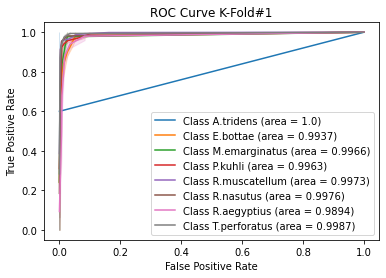

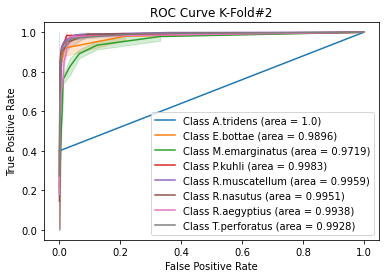

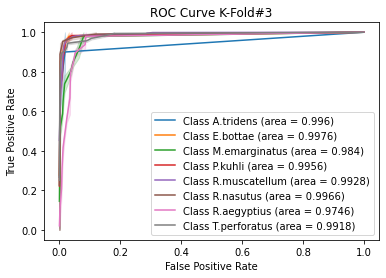

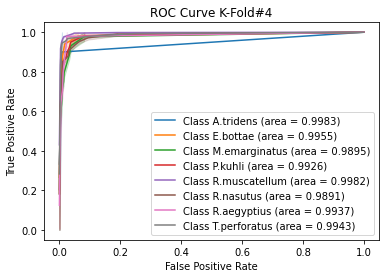

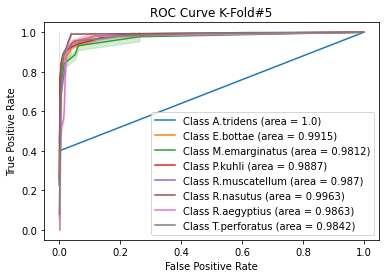

In [27]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

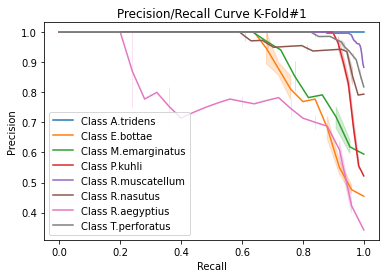

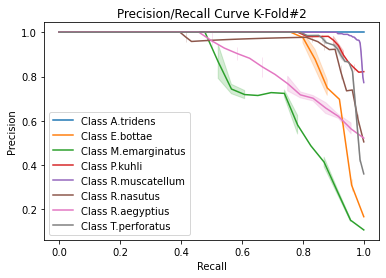

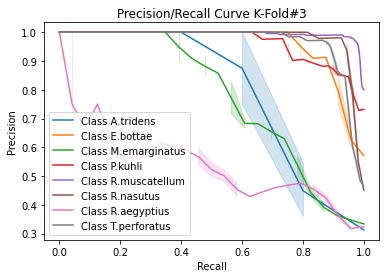

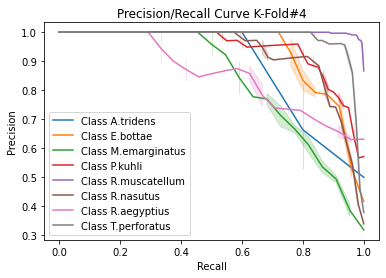

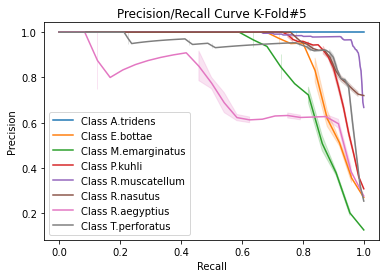

In [28]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  5   0   0   0   0   0   0   0]
 [  0  18   0   0   3   3   0   1]
 [  0   0  15   1   0   0   5   1]
 [  0   0   0  54   3   0   2   0]
 [  0   2   0   1 328   0   1   1]
 [  0   0   0   1   2  50   1   0]
 [  0   0   1   0   2   0  21   1]
 [  0   0   0   1   4   0   0  76]]


Confusion Matrix K-Fold #2

[[  5   0   0   0   0   0   0   0]
 [  0  21   0   0   1   2   1   0]
 [  0   0  15   4   2   0   2   0]
 [  0   0   2  57   1   0   0   0]
 [  0   2   0   1 325   0   4   1]
 [  0   2   0   4   1  44   2   0]
 [  0   0   1   0   1   0  22   0]
 [  0   1   3   0   4   0   4  69]]


Confusion Matrix K-Fold #3

[[  3   0   1   0   0   0   1   0]
 [  0  22   0   1   0   1   0   0]
 [  0   0  18   3   2   0   0   0]
 [  0   1   3  56   0   0   0   0]
 [  0   1   1   1 327   0   2   1]
 [  0   0   1   4   0  48   1   0]
 [  0   2   7   1   4   0   9   1]
 [  0   0   1   1  10   0   2  67]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   2   0]
 [  

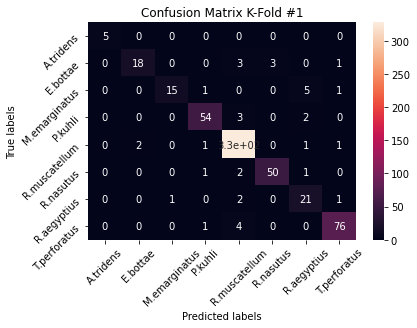

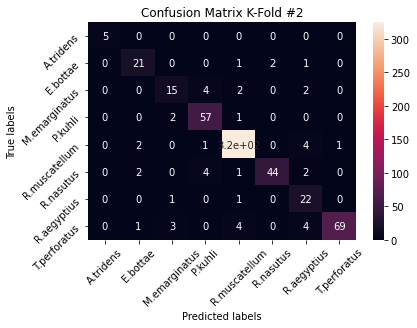

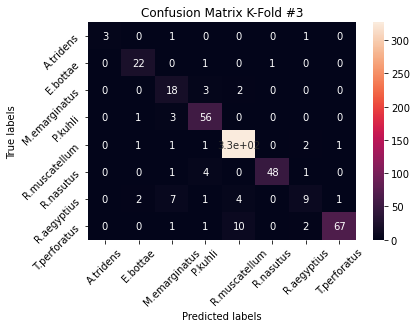

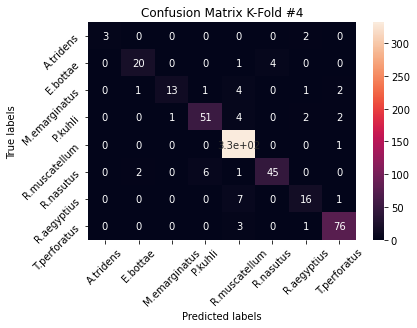

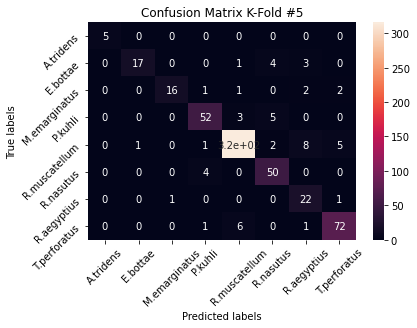

In [29]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  21    0    1    0    0    0    3    0]
 [   0   98    0    1    6   14    4    1]
 [   0    1   77   10    9    0   10    5]
 [   0    1    6  270   11    5    4    2]
 [   0    6    1    4 1628    2   15    9]
 [   0    4    1   19    4  237    4    0]
 [   0    2   10    1   14    0   90    4]
 [   0    1    4    3   27    0    8  360]]

average of all confuion matrices
 [[  4   0   0   0   0   0   0   0]
 [  0  19   0   0   1   2   0   0]
 [  0   0  15   2   1   0   2   1]
 [  0   0   1  54   2   1   0   0]
 [  0   1   0   0 325   0   3   1]
 [  0   0   0   3   0  47   0   0]
 [  0   0   2   0   2   0  18   0]
 [  0   0   0   0   5   0   1  72]]


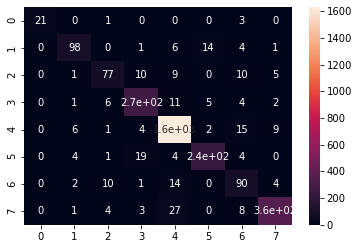

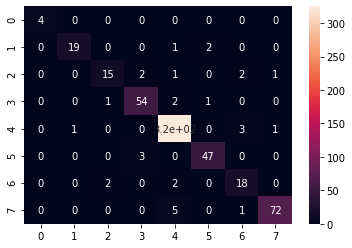

In [30]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.84 0.   0.04 0.   0.   0.   0.12 0.  ]
 [0.   0.79 0.   0.01 0.05 0.11 0.03 0.01]
 [0.   0.01 0.69 0.09 0.08 0.   0.09 0.04]
 [0.   0.   0.02 0.9  0.04 0.02 0.01 0.01]
 [0.   0.   0.   0.   0.98 0.   0.01 0.01]
 [0.   0.01 0.   0.07 0.01 0.88 0.01 0.  ]
 [0.   0.02 0.08 0.01 0.12 0.   0.74 0.03]
 [0.   0.   0.01 0.01 0.07 0.   0.02 0.89]]


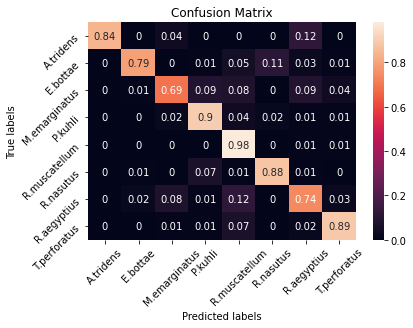

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);